# 전복 나이 예측 경진대회 베이스라인

이번 대회는 주어진 전복의 크기, 성별 등의 정보들을 통해 전복 나이를 예측하는 정형데이터 대회입니다.

언뜻보면 간단해 보이지만 처음 데이터 분석을 접하시는 분들에게는 어디부터 어떻게 시작해야 하는지 막막하실 겁니다.

이번 베이스라인에서는 간단하게 데이터 전처리, 그리고 모델 학습과 추론을 진행해보겠습니다.

# 1. 학습 데이터 불러오기

먼저 분석하려는 데이터를 작업장으로 가져오는 작업이 필요합니다.

이를 위해서 파이썬 라이브러리 중 하나인 Pandas를 이용합니다.

pandas 라이브러리는 엑셀과 같은 행과 열로 이루어진 테이블(table) 형식의 데이터를 편하게 다루도록 해주는 라이브러리입니다.

데이터 분석에는 반드시 사용된다고 해도 과언이 아닌 라이브러리이니, 시간이 날때마다 공부해둡시다.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

# csv형식으로 된 데이터 파일을 읽어옵니다.
train_df = pd.read_csv('./dataset/train.csv')
train_df.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,1,M,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,15
1,2,I,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8
2,3,I,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,18
3,4,M,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,13
4,5,I,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,6


데이터를 더 자세히 살펴보는 것은 EDA 글을 통해 더 자세히 배워봅시다.

여기에는 분석 방법에 초점을 맞추겠습니다.

# 2. 결측치 확인

결측치(NA: Not Available)란 값이 누락된 데이터를 말합니다.

보다 정확한 분석을 하기 위해서는 데이터의 결측치를 확인하고 적절히 처리해주어야 합니다.

이번 데이터에 결측치가 있나 확인해볼까요?

In [3]:
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train_df)

결측치가 존재하지 않습니다


이번 데이터에는 결측치가 존재하지 않습니다.

# 3. 데이터 전처리

## 데이터 인코딩
머신러닝 알고리즘은 문자열 데이터 속성을 입력받지 않으며 모든 데이터는 숫자형으로 표현되어야 합니다.

그래서 문자형 카테고리형 속성은 모두 숫자 값으로 변환/인코딩 되어야 합니다.

이번에 적용해볼 인코딩 방식은 'Label Encoding' 입니다.

Label Encoding이란, 범주형 변수의 문자열을 수치형으로 변환하는 방법 중 하나입니다.

우리 데이터에는 Gender라는 Feautre의 항목이 문자로 이루어져있기 때문에, 이것을 Label Encoding을 통해 숫자형으로 표현해보겠습니다.

In [4]:
#라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i+1  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    print(label_maps)
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

In [5]:
train_le = make_label_map(train_df[['Gender']])
gender_df = label_encoder(train_df[['Gender']], train_le)
train_df['Gender'] = gender_df[['Gender']]

{'Gender': {'unknown': 0, 'M': 1, 'I': 2, 'F': 3}}


In [6]:
train_df.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,1,1,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,15
1,2,2,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8
2,3,2,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,18
3,4,1,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,13
4,5,2,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,6


다음과 같이 Label Encoding을 통해서 Gender에 해당하는 데이터들이 모두 숫자형으로 변환됨을 확인할 수 있습니다.

다시말하자면, Gender 부분의 데이터에서 결측치는 0, M은 1, I는 2, F는 3으로 변환해주었습니다.

본격적으로 모델 학습을 위해 학습 데이터와 Target을 분리합니다. 

In [7]:
train_x = train_df.drop(['id', 'Target'], axis=1)
train_y = train_df.Target

# 4. 모델 학습 (Model Train)
## RandomForest

이번 베이스라인에서는 대표적인 ML모델의 하나인 RandomForest Regressor 모델을 사용해봅시다.

Regressor 모델을 사용하는 이유는, 우리가 이번 대회에서 예측해야할 전복 나이가 연속형 변수인 나이이기 때문입니다.

RandomForest 알고리즘에서 사용되는 의사 결정 트리는 feature 별 가지치기를 통해 데이터를 학습하는 알고리즘입니다.

의사 결정 트리에 대한 자세한 개념 설명은 데이콘 [오늘의 파이썬](https://dacon.io/competitions/open/235698/talkboard/403509?page=1&dtype=recent)을 참고해 주세요!

데이터를 쉽게 학습하는 알고리즘이지만 하나의 의사 결정 트리를 사용하는 것은 과적합(overfitting)의 문제를 발생 시킬 수 있습니다.

여기서 과적합(overfitting)이란 학습 데이터에 과하게 학습되어 새로운 데이터를 예측하지 못하는 문제를 말합니다. 

쉽게 말해 우리가 공부를 할때 암기식으로 공부를 하여 새로운 문제를 해결하지 못하는 것 입니다!

RandomForest는 여러개의 의사 결정 트리를 활용하여 과적합의 문제를 해결합니다.

여러개의 의사 결정 트리를 활용하면 하나의 트리에 대한 의존도가 낮아집니다. 

이는 하나의 트리가 과적합이 되어도 전체 모델은 과적합의 문제에서 벗어날 수 있음을 의미합니다.

In [8]:
#from IPython.display import display, Image
#display(Image(filename='./image/randomforest.jpg'))

[(Source: Analytics Vidhya)](https://www.analyticsvidhya.com/)

## Bagging

RandomForest 는 데이터가 모델에 투입되기 전 데이터를 여러개의 부분 집합으로 분할하고 이를 통해 여러개의 의사 결정 트리를 생성합니다.

이 과정을 bagging 이라 합니다.

bagging 기법은 데이터의 부분집합들을 생성하여 하나의 모델에 대한 의존도를 낮추는 효과가 있습니다. 

따라서 bagging 은 RandomForest 뿐만이 아닌 다른 앙상블(ensemble) 알고리즘에도 자주 사용됩니다.

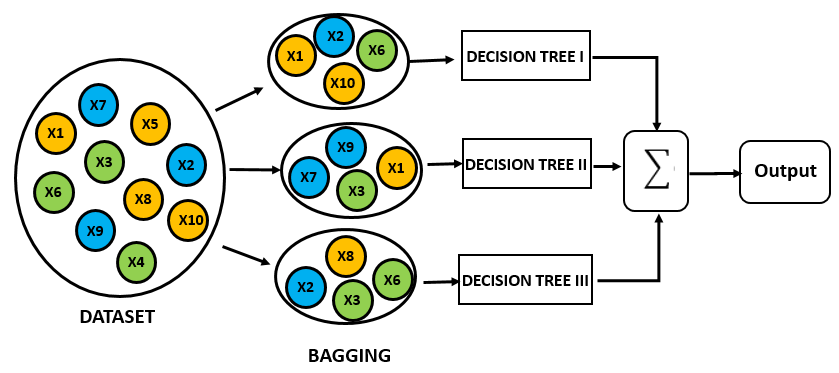

In [ ]:
#from IPython.display import display, Image
#display(Image(filename='./image/bagging.png'))

[(Source: Medium)](https://medium.com/)

각 트리들은 서로 다른 데이터를 입력 받지만, 모두 training 데이터의 부분집합입니다.

그렇다면 왜 RandomForest는 의사 결정 트리를 만드는데 있어서 모든 데이터를 고려하지 않을까요?

여러개의 의사 결정 나무에 같은 데이터를 학습 시킨다면 같은 의사 결정 나무가 산출되기 때문입니다. 

같은 의사 결정 나무들이 산출 된다면 앙상블 기법의 의미가 없습니다.

즉, Bagging을 활용하므로서 다양한 의사 결정 나무들이 산출되는 것입니다. 

이렇게 산출된 다양한 의사 결정 트리들이 모여 집단 지성을 이루는 것이 RandomForest 알고리즘입니다.

## 모델 선언과 모델 학습

sklearn 패키지를 이용하면 직접 RandomForest를 구현하지 않고 모델을 사용할 수 있습니다.

이번 베이스라인에서는 sklearn에서 제공하는 RandomForestRegressor를 사용해보겠습니다.

Regerssion task 에서 앙상블 모델은 각 모델들의 예측 값의 평균을 최종 예측 값으로 산출 합니다. 

따라서 각 의사 결정 트리들의 예측 값의 평균이 RandomForestRegressor 의 최종 예측 값이 되는 것입니다.

In [9]:
from sklearn.ensemble import RandomForestRegressor

In [10]:
model = RandomForestRegressor() # 모델을 객체에 할당

model.fit(train_x, train_y) # 모델 학습

RandomForestRegressor()

# 6. 추론 (Inference)

모델 학습이 완료되었다면, 이제 test 데이터를 통하여 전복나이를 예측해보겠습니다.

In [11]:
# csv형식으로 된 데이터 파일을 읽어옵니다.
test_df = pd.read_csv('./dataset/test.csv')
test_df.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight
0,1,F,0.595,0.470,0.155,1.121,0.4515,0.1780,0.1550
1,2,M,0.580,0.450,0.150,0.927,0.2760,0.1815,0.3600
2,3,I,0.260,0.205,0.070,0.097,0.0415,0.0190,0.0305
3,4,M,0.590,0.460,0.130,1.102,0.4550,0.2055,0.3300
4,5,F,0.595,0.465,0.140,1.113,0.5175,0.2440,0.3050


학습 데이터에 했던 전처리 과정(Label인코딩)을 테스트 데이터에도 해줍니다.

단, 학습 데이터에 학습된 인코더를 사용해 주어야 합니다.

(테스트 데이터를 학습 시킨 인코더를 사용하면 data leakage 에 해당됩니다!)

In [12]:
gender_df = label_encoder(test_df[['Gender']], train_le)
test_df['Gender'] = gender_df[['Gender']]

test_df.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight
0,1,3,0.595,0.470,0.155,1.121,0.4515,0.1780,0.1550
1,2,1,0.580,0.450,0.150,0.927,0.2760,0.1815,0.3600
2,3,2,0.260,0.205,0.070,0.097,0.0415,0.0190,0.0305
3,4,1,0.590,0.460,0.130,1.102,0.4550,0.2055,0.3300
4,5,3,0.595,0.465,0.140,1.113,0.5175,0.2440,0.3050


In [13]:
test_x = test_df.drop(['id'],axis=1)

In [14]:
# 전처리가 완료된 테스트 데이터셋을 통해 본격적으로 학습한 모델로 추론을 시작합니다.
prediction = model.predict(test_x)

# 7. Dacon 대회에 제출하기 (Submission)

이제 이 예측 결과를 submission.csv 파일로 만들어서 대회 페이지에 제출해보도록 합시다.

제출한 뒤 리더보드를 통해 결과를 확인합시다.

In [16]:
# 제출용 Sample 파일을 불러옵니다
submission = pd.read_csv('./dataset/sample_submission.csv')
submission.head()

,id,Target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [17]:
submission['Target'] = prediction

# 데이터가 잘 들어갔는지 확인합니다
submission

,id,Target
0,1,8.49
1,2,12.57
2,3,5.39
3,4,11.08
4,5,10.26
...,...,...
2919,2920,4.03
2920,2921,6.90
2921,2922,9.42
2922,2923,10.69


In [18]:
submission.to_csv('submit.csv', index=False)